## Background

This project aims to define a classifier that extracts latent representations and visualize them. The second part focuses on clustering with different representations. The final section attems nearest neighbors using these representations.

## 1.1 - Simple residual CNN with batchnorm and data loaders

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

class SimpleResidualBlock(nn.Module):
    def __init__(self, ch_in, mult=4):
        super().__init__()
        self.conv1 = nn.Conv2d(ch_in, mult * ch_in, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(mult * ch_in)

        self.conv2 = nn.Conv2d(mult * ch_in, mult * ch_in, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(mult * ch_in)

        self.conv3 = nn.Conv2d(mult * ch_in, ch_in, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(ch_in)

    def forward(self, x):
        x_ = x.clone()
        x_ = torch.relu(self.bn1(self.conv1(x_)))
        x_ = torch.relu(self.bn2(self.conv2(x_)))
        x_ = torch.relu(self.bn3(self.conv3(x_)))
        x = x + x_
        return x

class SimpleResNet(nn.Module):
    def __init__(self, ch_in, n_blocks=3):
        super().__init__()
        self.residual_layers = nn.ModuleList([SimpleResidualBlock(ch_in) for i in range(n_blocks)])
        self.maxpool = nn.MaxPool2d((2, 2))
        self.fc = nn.Linear(9, 10)

    def forward(self, x):
        for residual in self.residual_layers:
          x = residual(x)
          x = self.maxpool(x)
        x = x.view(x.shape[0], -1)  # Unravel tensor dimensions
        out = self.fc(x)
        return out

100%|██████████| 9912422/9912422 [00:00<00:00, 300708895.94it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 107676172.29it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 123308693.73it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 17193618.02it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



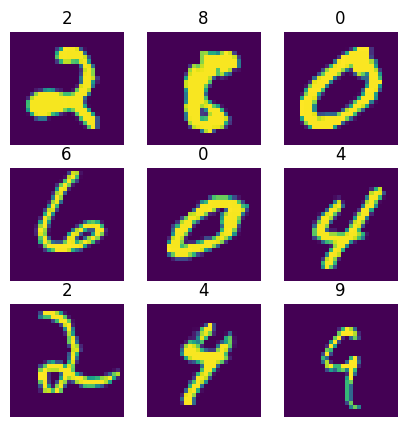

In [ ]:
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Create MNIST datasets
classes = np.arange(10)
transform = torchvision.transforms.Compose(
  [torchvision.transforms.ToTensor(),
   torchvision.transforms.Normalize((0.1307,),(0.3081,))])
train_dataset = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform)

# Create dataloaders
batch_size_train, batch_size_test = 64, 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

# Show sample images
batch_idx, (images, targets) = next(enumerate(train_loader))
fig, ax = plt.subplots(3,3,figsize = (5,5))
for i in range(3):
  for j in range(3):
    image = images[i*3+j].permute(1,2,0)
    image = image/2 + 0.5
    ax[i,j].imshow(image.squeeze(2))
    ax[i,j].set_title(f'{classes[targets[i*3+j]]}')
    ax[i,j].axis('off')
fig.show()

## 1.2 - Inherit the original model class and define a new function returning the same output with the parent's forward function as well as intermediate representations (including the original input)

Specifically, the function below returns the original output from `forward` function of the parent's class and a list of intermediate representations `z_list`. `z_list` is a Python list with 4 entries corresponding to the original batch and the batch **after each maxpool layer.**

In [ ]:
# Trivial example below
class AffineModel(nn.Module):
    def __init__(self, A, b):
        super().__init__()
        self.A, self.b = A, b
    def forward(self, x):
        x = torch.matmul(x, self.A)
        return x + self.b
class ExtractAffineModel(AffineModel):
    def compute_and_extract_representations(self, x):
        z_list = [x]
        x = torch.matmul(x, self.A)
        z_list.append(x)
        return x + self.b, z_list

In [ ]:
class SimpleResNetWithRepresentations(SimpleResNet):
  def compute_and_extract_representations(self, x):
    z_list = [x]
    for residual in self.residual_layers:
      x = residual(x)
      x = self.maxpool(x)
      z_list.append(x)
    x = x.view(x.shape[0], -1)  # Unravel tensor dimensions
    out = self.fc(x)
    return out, z_list

model = SimpleResNetWithRepresentations(ch_in=1)
model.to(device)
images, labels = next(iter(test_loader)) # get a batch
images = images.to(device)
# Check that outputs match
out, z_list = model.compute_and_extract_representations(images)
assert torch.all(model(images) == out), 'Outputs should be the same'
# Check shapes of representations
assert len(z_list) == 4, 'Should have length of 4'
assert torch.all(z_list[0] == images), 'First entry should be original data'
for zi, z in enumerate(z_list):
  print(f'Representation z{zi} batch shape = {z.shape}')

Representation z0 batch shape = torch.Size([128, 1, 28, 28])
Representation z1 batch shape = torch.Size([128, 1, 14, 14])
Representation z2 batch shape = torch.Size([128, 1, 7, 7])
Representation z3 batch shape = torch.Size([128, 1, 3, 3])


## 1.3 - Train the model

Train `model` for 4 epochs using the Adam optimizer with a learning rate of 0.01.

In [ ]:
def train(epoch, model, optimizer):
    model.train() 
    for batch_idx, (images, targets) in enumerate(train_loader):
      images = images.to(device)
      targets = targets.to(device)
      optimizer.zero_grad()
      output = model(images)
      loss = F.cross_entropy(output, targets) #typical loss function
      loss.backward()
      optimizer.step()
      if batch_idx % 100 == 0: # visulize output every 10 batches
        print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item()}')

def test(epoch, model):
  model.eval() # set the mode for model
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for images, targets in test_loader:
      images = images.to(device)
      targets = targets.to(device)
      output = model(images)
      test_loss += F.cross_entropy(output, targets, reduction='sum').item()
      pred = output.data.max(1, keepdim=True)[1] 
      correct += pred.eq(targets.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  print(f'Test result on epoch {epoch}: Avg loss is {test_loss}, Accuracy: {100.*correct/len(test_loader.dataset)}%')

optimizer = optim.Adam(model.parameters(), lr=0.01)
for epoch in range(4):
  train(epoch, model, optimizer)
  test(epoch, model)

Epoch 0: [0/60000] Loss: 3.988192558288574
Epoch 0: [6400/60000] Loss: 1.039493441581726
Epoch 0: [12800/60000] Loss: 0.758212685585022
Epoch 0: [19200/60000] Loss: 0.5766721367835999
Epoch 0: [25600/60000] Loss: 0.5306764841079712
Epoch 0: [32000/60000] Loss: 0.3603828251361847
Epoch 0: [38400/60000] Loss: 0.2624450922012329
Epoch 0: [44800/60000] Loss: 0.4288926422595978
Epoch 0: [51200/60000] Loss: 0.15844501554965973
Epoch 0: [57600/60000] Loss: 0.22885653376579285
Test result on epoch 0: Avg loss is 0.2764572848320007, Accuracy: 91.18000030517578%
Epoch 1: [0/60000] Loss: 0.20937523245811462
Epoch 1: [6400/60000] Loss: 0.33370447158813477
Epoch 1: [12800/60000] Loss: 0.29711100459098816
Epoch 1: [19200/60000] Loss: 0.2737910747528076
Epoch 1: [25600/60000] Loss: 0.34660759568214417
Epoch 1: [32000/60000] Loss: 0.19971856474876404
Epoch 1: [38400/60000] Loss: 0.27441373467445374
Epoch 1: [44800/60000] Loss: 0.19042611122131348
Epoch 1: [51200/60000] Loss: 0.16090676188468933
Epoch 

## 1.4 - Visualize the intermediate latent representations

Plot representations of 20 images from the test dataset in a supblots grid of shape (20, 4) where the rows correspond to samples in the dataset and columns correspond to the representations produced by `compute_and_extract_representations`

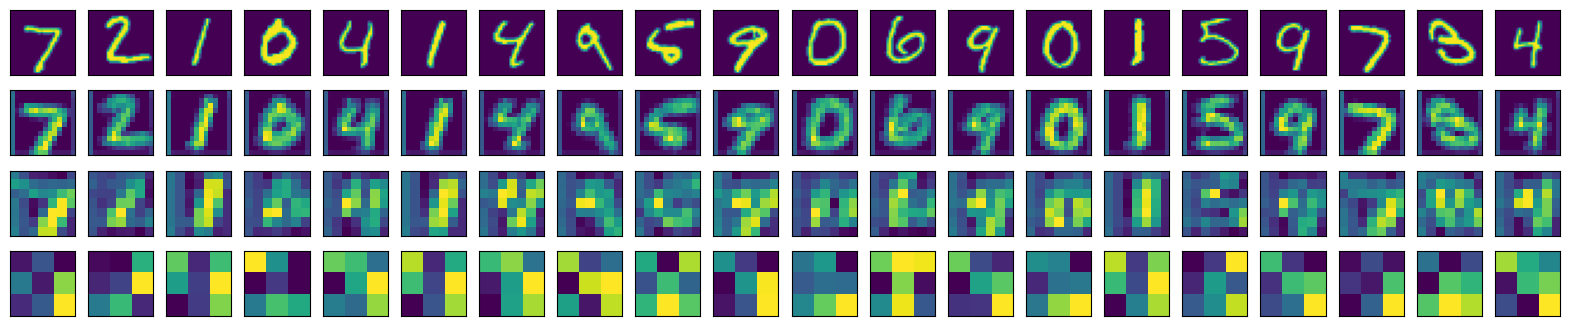

In [ ]:
def plot_representation(z, ax):
  # Normalize image for visualization
  assert z.ndim == 3, 'Should be 3 dimensional tensor with C x H x W'
  z = (z - z.min())/(z.max() - z.min())
  if torch.is_tensor(z):  # Convert torch tensor to numpy if needed
    z = z.detach().cpu().numpy()
  ax.imshow(z.transpose((1,2,0)).squeeze(2))
  # Remove ticks and ticklabels to make plot clean
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xticklabels([])
  ax.set_yticklabels([])

n_show = 20
fig, axes_mat = plt.subplots(4, n_show, figsize=[n_show, 4])
model.eval()
for i in range(n_show):
  images, labels = next(iter(test_loader))
  images = images.to(device)
  out, z_list = model.compute_and_extract_representations(images)
  for j, z in enumerate(z_list):
    plot_representation(z[i], axes_mat[j, i])

## 2.1 - Create simple numpy arrays of the representations

In [ ]:
def extract_numpy_representations(model, data_loader, n_extract):
  extracted_z_lists = []
  labels_list = []
  for batch_idx, (images, labels) in enumerate(data_loader):
    images = images.to(device)
    labels = labels.to(device)
    out, z_list = model.compute_and_extract_representations(images)
    extracted_z_lists.append(z_list)
    labels_list.append(labels)
    if (batch_idx + 1) * len(images) >= n_extract:
      break
  # Check extracted_z_lists)
  print(f'Types of first batch\n    {[type(z) for z in extracted_z_lists[0]]}')
  print(f'Shapes of first batch\n    {[z.shape for z in extracted_z_lists[0]]}')

  # Merge extracted z_lists and labels and make numpy arrays
  z_list_merge_np = [
    np.vstack([
      z_list[i].detach().cpu().numpy()
      for z_list in extracted_z_lists
    ])[:n_extract]  # Extract up to n_extract
    for i in range(len(extracted_z_lists[0]))
  ]
  print(f'Types of merged lists\n    {[type(z) for z in z_list_merge_np]}')
  print(f'Shapes of merged lists\n    {[z.shape for z in z_list_merge_np]}')
  labels_merged_np = np.concatenate([
    labels.detach().cpu().numpy()
    for labels in labels_list
  ])[:n_extract]  # Extract up to n_extract
  print(f'Shape of merged labels\n    {labels_merged_np.shape}')
  return z_list_merge_np, labels_merged_np

# Extract train and test samples
z_list_train, labels_train = extract_numpy_representations(model, train_loader, n_extract=200)
z_list_test, labels_test = extract_numpy_representations(model, test_loader, n_extract=200)
# Extract regular train and test
x_test = z_list_test[0]
x_train = z_list_train[0]

Types of first batch
    [<class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>]
Shapes of first batch
    [torch.Size([64, 1, 28, 28]), torch.Size([64, 1, 14, 14]), torch.Size([64, 1, 7, 7]), torch.Size([64, 1, 3, 3])]
Types of merged lists
    [<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>]
Shapes of merged lists
    [(200, 1, 28, 28), (200, 1, 14, 14), (200, 1, 7, 7), (200, 1, 3, 3)]
Shape of merged labels
    (200,)
Types of first batch
    [<class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>]
Shapes of first batch
    [torch.Size([128, 1, 28, 28]), torch.Size([128, 1, 14, 14]), torch.Size([128, 1, 7, 7]), torch.Size([128, 1, 3, 3])]
Types of merged lists
    [<class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>]
Shapes of merged lists
    [(200, 1, 28, 28), (200, 1, 14, 14), (200, 1, 7, 7), (200, 1, 3

## 2.2 - K-means clustering on different representations

In [ ]:
def plot_cluster(cluster_labels, z_test, title):
  # Plot the top images in each cluster both in original space and latent representation
  n_samples_show, n_clusters = 5, 10
  nr, nc = n_samples_show, 2*n_clusters
  fig, axes_mat = plt.subplots(nr, nc, figsize=np.array([nc, nr])/2)
  axes_mat_list = np.split(axes_mat, n_clusters, axis=1)
  for ci, axes_mat in enumerate(axes_mat_list): # Loop over clusters
    sel = cluster_labels==ci
    z_cluster = z_test[sel][:n_samples_show]
    x_cluster = x_test[sel][:n_samples_show]
    for test_i, (z, x, axes) in enumerate(zip(z_cluster, x_cluster, axes_mat)):
      plot_representation(x, axes[0])
      plot_representation(z, axes[1])
      if ci == 0:
        axes[0].set_ylabel(test_i)
      if test_i == len(axes_mat)-1:
        axes[0].set_xlabel(f'C{ci}x')
        axes[1].set_xlabel(f'C{ci}z')
  fig.suptitle(title)
  plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

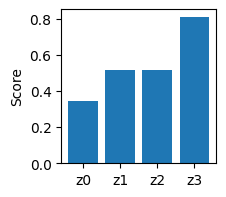

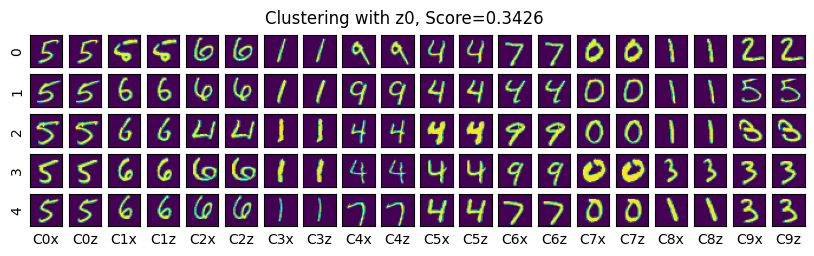

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


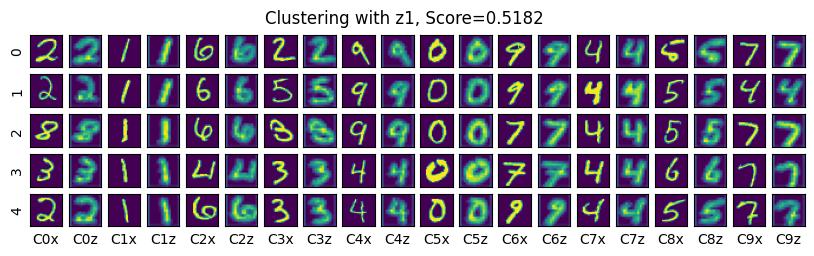

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


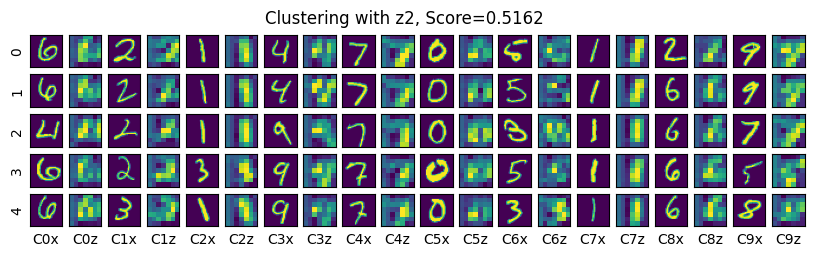

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


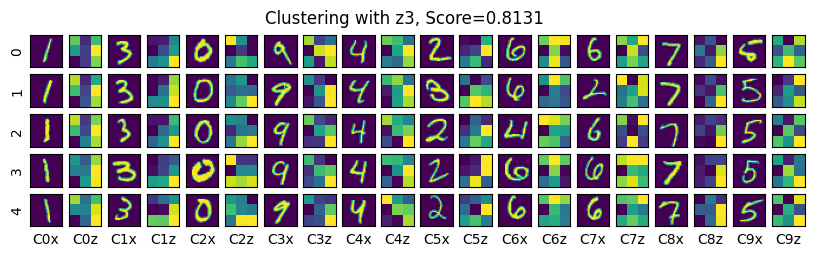

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

def cluster_and_score(z, true_labels):
  z = z.reshape(z.shape[0], -1)
  kmeans = KMeans(n_clusters=10, random_state=0).fit(z)
  cluster_labels = kmeans.labels_
  score = adjusted_rand_score(true_labels, cluster_labels)
  return cluster_labels, score

fig = plt.figure(figsize=(2,2))
plt.bar([f'z{zi}' for zi in range(len(z_list_test))],
        [cluster_and_score(z_test, labels_test)[1] for z_test in z_list_test])
plt.ylabel('Score')
for zi, z_test in enumerate(z_list_test):
  cluster_labels, score = cluster_and_score(z_test, labels_test)
  plot_cluster(cluster_labels, z_test, f'Clustering with z{zi}, Score={score:.4f}')


## 3.1 - Compute and plot nearest neigbhors in different representations

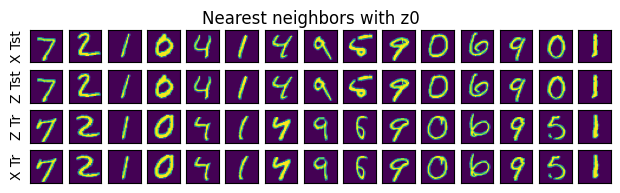

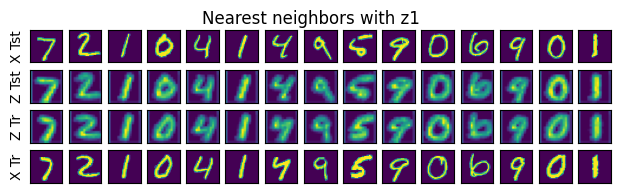

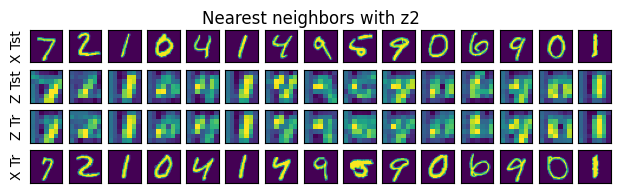

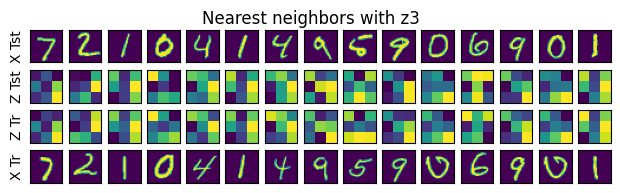

In [ ]:
from sklearn.neighbors import NearestNeighbors

def plot_neigbhor(test_ind, nearest_train_ind, z_test, z_train, title):
  '''
  Plots the original test image, the test image representation,
    the nearest train image representation, the nearest original train image.
  '''
  assert len(test_ind) == len(nearest_train_ind), 'Test and train indices should be the same length'
  n_test = len(test_ind)
  fig, axes_mat = plt.subplots(4, n_test, figsize=np.array([n_test, 4])/2)
  for test_i, nearest_train_i, axes in zip(test_ind, nearest_train_ind, axes_mat.T):
    plot_representation(x_test[test_i], axes[0])
    plot_representation(z_test[test_i], axes[1])
    plot_representation(z_train[nearest_train_i], axes[2])
    plot_representation(x_train[nearest_train_i], axes[3])
    if test_i == 0:
      for lab, ax in zip(['X Tst', 'Z Tst', 'Z Tr', 'X Tr'], axes):
        ax.set_ylabel(lab)
  fig.suptitle(title)


for zi, (z_test, z_train) in enumerate(zip(z_list_test, z_list_train)):
  z_test_flattened = z_test.reshape(z_test.shape[0], -1)
  z_train_flattened = z_train.reshape(z_train.shape[0], -1)
  neigh = NearestNeighbors(n_neighbors=1)
  neigh.fit(z_train_flattened)
  _, nearest_train_ind = neigh.kneighbors(z_test_flattened[:15])
  plot_neigbhor(np.arange(15), nearest_train_ind.squeeze(), z_test, z_train, f'Nearest neighbors with z{zi}')